# This is the keras version of MediaEval 2018

Contents

## This is third test
## Here, using the pre-trained network to classify medical images (8 classes)
##  Modified for medical image classification

### pretrained network name = VGG16

In [3]:
from keras.applications import VGG16
import os
import shutil
import datetime

Using TensorFlow backend.


In [4]:
from keras.preprocessing.image import ImageDataGenerator
import pickle # to save history file of training
from keras import models
from keras import layers
from keras import optimizers

import matplotlib as mpl
import matplotlib.pyplot as plt

In [5]:
plt.rcParams['figure.figsize'] = [15, 10]

###### Initial Data handling

In [6]:
base_dir = 'data'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')


main_classification_types = ['dyed-lifted-polyps',
                             'dyed-resection-margins',
                             'esophagitis',
                             'normal-cecum',
                             'normal-pylorus',
                             'normal-z-line',
                             'polyps',
                             'ulcerative-colitis']

# original data location path
orginal_data_folder = '/home/vajira/simula/Datasets/kvasir_v2_preprocessed_borders_navbox_removed'

###### Parameters

In [20]:
no_of_classes = 8
train_size = 500
validation_size = 250
test_size = 250

img_height = 150
img_width = 150

batch_size = 50
no_of_epochs = 5

training_steps_per_epoch = (train_size * no_of_classes) / batch_size

validation_steps = (validation_size * no_of_classes) / batch_size

test_steps = (test_size * no_of_classes) / batch_size

In [8]:
print('trainig steps per epoch =', training_steps_per_epoch)
print('validation steps per epoch =', validation_steps)

trainig steps per epoch = 80.0
validation steps per epoch = 40.0


##### Generating data sets from the original data set

In [9]:
def make_folder_structure(base_dir, main_classification_types_dirs):

    train_dir_list = []
    validation_dir_list = []
    test_dir_list = []


    if not os.path.exists(base_dir):
        os.mkdir(base_dir)  # new directory to make directory structure and load data

    main_directory_names = ['train', 'validation', 'test']

    for main_dir_name in main_directory_names:
        dir = os.path.join(base_dir, main_dir_name)
        if not os.path.exists(dir):
            os.mkdir(dir)

        for main_classification_types_dir in main_classification_types_dirs:
            type_dir = os.path.join(dir, main_classification_types_dir)

            if main_dir_name == 'train':
                train_dir_list.append(type_dir)

            elif main_dir_name == 'validation':
                validation_dir_list.append(type_dir)

            elif main_dir_name == 'test':
                test_dir_list.append(type_dir)

            if not os.path.exists(type_dir):
                os.mkdir(type_dir)

    return train_dir_list, validation_dir_list, test_dir_list


In [10]:
make_folder_structure(base_dir, main_classification_types)  # making the folder structure

(['data/train/dyed-lifted-polyps',
  'data/train/dyed-resection-margins',
  'data/train/esophagitis',
  'data/train/normal-cecum',
  'data/train/normal-pylorus',
  'data/train/normal-z-line',
  'data/train/polyps',
  'data/train/ulcerative-colitis'],
 ['data/validation/dyed-lifted-polyps',
  'data/validation/dyed-resection-margins',
  'data/validation/esophagitis',
  'data/validation/normal-cecum',
  'data/validation/normal-pylorus',
  'data/validation/normal-z-line',
  'data/validation/polyps',
  'data/validation/ulcerative-colitis'],
 ['data/test/dyed-lifted-polyps',
  'data/test/dyed-resection-margins',
  'data/test/esophagitis',
  'data/test/normal-cecum',
  'data/test/normal-pylorus',
  'data/test/normal-z-line',
  'data/test/polyps',
  'data/test/ulcerative-colitis'])

In [11]:
def load_data_to_folder(original_data_folder, # original data folder
                        base_dir,  # folder to create training, validation and testing data
                        main_classification_types,  # main class types of the problem
                        size_of_training,  # number of images to training set
                        size_of_validation,  # number of images to validation set
                        size_of_testing):  # number of images to testing set

    for class_type in main_classification_types:
        src_dir = os.path.join(original_data_folder, class_type)
        files = os.listdir(src_dir)

        training_files = files[0:size_of_training]
        validation_files = files[size_of_training:size_of_training + size_of_validation]
        testing_files = files[size_of_training + size_of_validation:size_of_training + size_of_validation + size_of_testing]

        print(len(files))

        # copying training images
        for file in training_files:
            src_file = os.path.join(src_dir, file)
            dst_file = os.path.join(base_dir + '/train/' + class_type, file)
            if not os.path.exists(dst_file):
                shutil.copyfile(src_file, dst_file)

        # copying validaton images
        for file in validation_files:
            src_file = os.path.join(src_dir, file)
            dst_file = os.path.join(base_dir + '/validation/' + class_type, file)
            if not os.path.exists(dst_file):
                shutil.copyfile(src_file, dst_file)

        # copying testing images
        for file in testing_files:
            src_file = os.path.join(src_dir, file)
            dst_file = os.path.join(base_dir + '/test/' + class_type, file)
            if not os.path.exists(dst_file):
                shutil.copyfile(src_file, dst_file)

        #training_dir = os.path.join(base_dir, 'train')



###### loading data to folders for trining, validation and testing

In [12]:
load_data_to_folder(orginal_data_folder, base_dir,
                    main_classification_types,
                    train_size, validation_size, test_size)


1000
1000
1000
1000
1000
1000
1000
1000


In [13]:
# the model directory
model_dir = 'my_models'
if not os.path.exists(model_dir):
    os.mkdir(model_dir, mode=0o777)

# history saving directory
history_dir = 'history_of_training'
if not os.path.exists(history_dir):
    os.mkdir(history_dir)

# plot directory
plot_dir = 'plots'
if not os.path.exists(plot_dir):
    os.mkdir(plot_dir)


##### Load VGG16 base

In [26]:
conv_base = VGG16(weights='imagenet',
                  include_top=False,  # removing densely connected classifier
                  input_shape=(img_width, img_height, 3))  # this is optional

##### Defining denesely connected classifier

In [27]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
#  model.add(layers.Dropout(0.5))
model.add(layers.Dense(8, activation='softmax')) ## change from sigmoid to softmax for 8 classes

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 2056      
Total params: 16,814,152
Trainable params: 16,814,152
Non-trainable params: 0
_________________________________________________________________


##### Testing trainable weights

In [28]:
print('Trainable weights before freezing conv base=', len(model.trainable_weights))

conv_base.trainable = False  # Freezing the base model weights and bias

print('Trainable weights after freezing conv base:', len(model.trainable_weights))

Trainable weights before freezing conv base= 30
Trainable weights after freezing conv base: 4


In [29]:
train_datagen = ImageDataGenerator(rescale=1. / 255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

In [15]:
test_datagen = ImageDataGenerator(rescale=1. / 255)

In [31]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),  # resize all the images to 150X150
    batch_size=batch_size,
    class_mode='categorical')  # because loss in binary crossentropy

Found 4000 images belonging to 8 classes.


In [16]:
validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 2000 images belonging to 8 classes.


In [17]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (img_width,img_height),
    batch_size= batch_size,
    class_mode = 'categorical')

Found 2000 images belonging to 8 classes.


In [33]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5), ## changed leraning rate to 0.1 after FastAI test
              metrics=['acc'])

In [34]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=training_steps_per_epoch,  # 500*8/50 = 80
    epochs=no_of_epochs,
    validation_data=validation_generator,
    validation_steps=validation_steps)  # 250*8/50 = 40

Epoch 1/5
80/80 [==============================] - 88s 1s/step - loss: 1.7864 - acc: 0.3380 - val_loss: 1.5073 - val_acc: 0.5015
Epoch 2/5
80/80 [==============================] - 81s 1s/step - loss: 1.4400 - acc: 0.4910 - val_loss: 1.2643 - val_acc: 0.5730
Epoch 3/5
80/80 [==============================] - 80s 1s/step - loss: 1.2467 - acc: 0.5755 - val_loss: 1.1219 - val_acc: 0.6015
Epoch 4/5
80/80 [==============================] - 79s 985ms/step - loss: 1.1322 - acc: 0.6058 - val_loss: 1.0361 - val_acc: 0.6165
Epoch 5/5
80/80 [==============================] - 79s 989ms/step - loss: 1.0647 - acc: 0.6220 - val_loss: 0.9567 - val_acc: 0.6560


##### Saving the model

In [35]:
model_name_string = 'medical_v1_' + datetime.datetime.now().strftime("%Y-%m-%d %H:%M") + '.h5'
model_fname = os.path.join(model_dir, model_name_string)
model.save(model_fname)
print('Model saved')

Model saved


In [36]:
model_fname

'my_models/medical_v1_2018-07-09 15:51.h5'

##### saving the training history for future graphing

In [37]:
history_string= 'history_of_medical_v1' + datetime.datetime.now().strftime("%Y-%m-%d %H:%M")
history_fname = os.path.join(history_dir, history_string)
f = open(history_fname, "wb+")
pickle.dump(history.history, f)
f.close()
print('History of the model saved')

History of the model saved


In [38]:
history_fname

'history_of_training/history_of_medical_v12018-07-09 15:52'

##### Plotting data to understand and save plots to plot folder

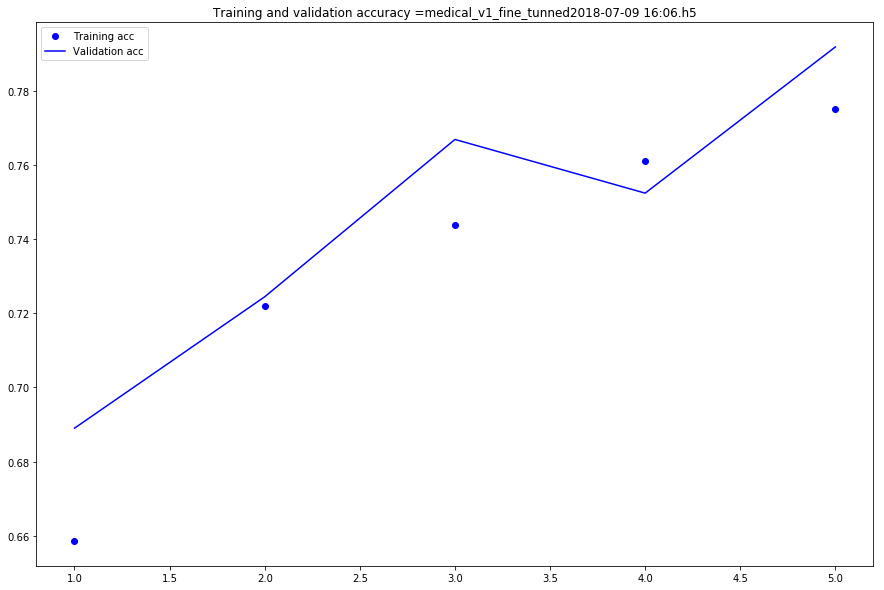

In [51]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
title_string = 'Training and validation accuracy =' + model_name_string
plt.title(title_string)
plt.legend()

In [40]:
plot_name = title_string + '.tiff'
plot_fname = os.path.join(plot_dir, plot_name)
plt.savefig(plot_fname)

<Figure size 432x288 with 0 Axes>

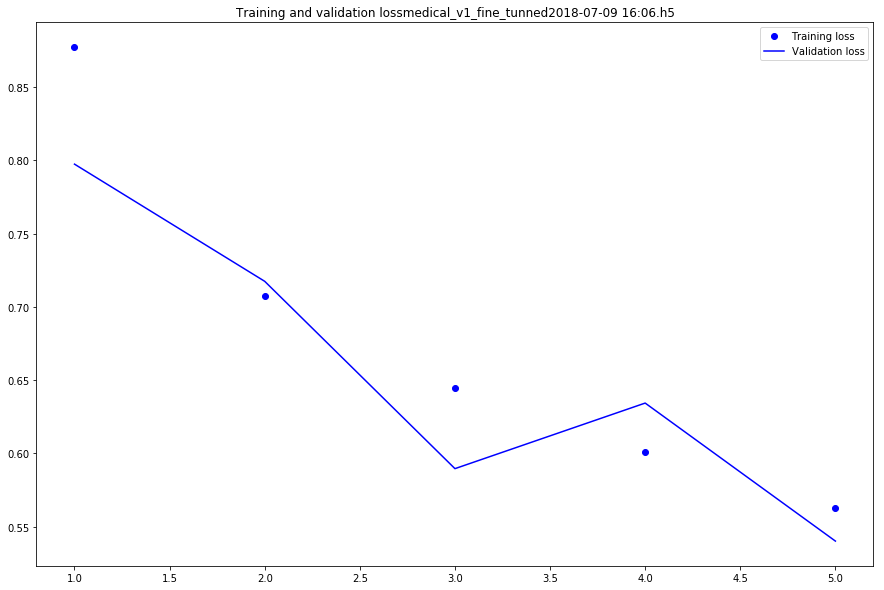

In [52]:
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
title_string = 'Training and validation loss' + model_name_string
plt.title(title_string)
plt.legend()

# To save plots - added by me
plot_name = title_string + '.tiff'
plot_fname = os.path.join(plot_dir, plot_name)
plt.savefig(plot_fname)

#### Starting Fine tuning

In [42]:
print('starting fine tuning')

conv_base.summary()

conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    print(layer.name)
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

starting fine tuning
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       

#### Recompiling with unfreez layers

In [43]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

In [44]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=training_steps_per_epoch,
    epochs=no_of_epochs,
    validation_data=validation_generator,
    validation_steps=validation_steps)

Epoch 1/5
80/80 [==============================] - 88s 1s/step - loss: 0.8775 - acc: 0.6585 - val_loss: 0.7975 - val_acc: 0.6890
Epoch 2/5
80/80 [==============================] - 80s 1s/step - loss: 0.7072 - acc: 0.7220 - val_loss: 0.7175 - val_acc: 0.7245
Epoch 3/5
80/80 [==============================] - 80s 1s/step - loss: 0.6448 - acc: 0.7440 - val_loss: 0.5896 - val_acc: 0.7670
Epoch 4/5
80/80 [==============================] - 80s 995ms/step - loss: 0.6010 - acc: 0.7613 - val_loss: 0.6343 - val_acc: 0.7525
Epoch 5/5
80/80 [==============================] - 79s 992ms/step - loss: 0.5628 - acc: 0.7752 - val_loss: 0.5401 - val_acc: 0.7920


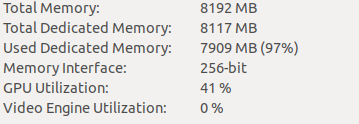

#### Saving the model again (fined tunes)

In [45]:
model_name_string = 'medical_v1_fine_tunned' + datetime.datetime.now().strftime("%Y-%m-%d %H:%M") + '.h5'
model_fname = os.path.join(model_dir, model_name_string)
model.save(model_fname)
print('Fined tunened Model saved')

Fined tunened Model saved


In [46]:
model_fname

'my_models/medical_v1_fine_tunned2018-07-09 16:06.h5'

#### saving the training history for future graphing

In [48]:
history_sting= 'history_of_v6_medical_fine_tunned' + datetime.datetime.now().strftime("%Y-%m-%d %H:%M")
history_fname = os.path.join(history_dir, history_sting)
f = open(history_fname, "wb+")
pickle.dump(history.history, f)
f.close()
print('History of the model saved')

History of the model saved


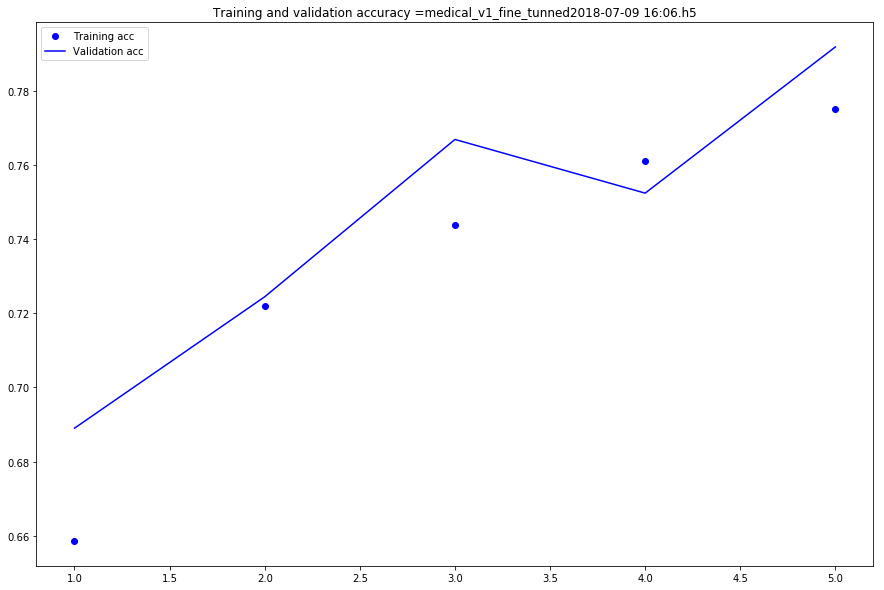

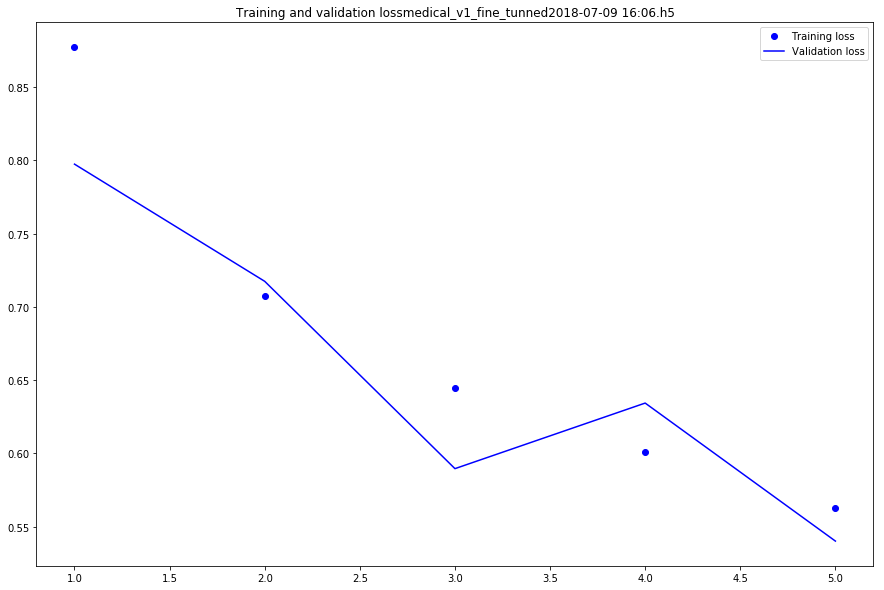

In [53]:
plt.figure()

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
title_string = 'Training and validation accuracy =' + model_name_string
plt.title(title_string)
plt.legend()

# To save plots - added by me
plot_name = title_string + '.tiff'
plot_fname = os.path.join(plot_dir, plot_name)
plt.savefig(plot_fname)
##############################

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
title_string = 'Training and validation loss' + model_name_string
plt.title(title_string)
plt.legend()

# To save plots - added by me
plot_name = title_string + '.tiff'
plot_fname = os.path.join(plot_dir, plot_name)
plt.savefig(plot_fname)

In [54]:
print('Test OK')

Test OK


In [55]:
model.load_weights('my_models/medical_v1_fine_tunned2018-07-09 16:06.h5')

In [56]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=training_steps_per_epoch,
    epochs=no_of_epochs,
    validation_data=validation_generator,
    validation_steps=validation_steps)

Epoch 1/5
80/80 [==============================] - 88s 1s/step - loss: 0.5368 - acc: 0.7867 - val_loss: 0.5223 - val_acc: 0.7940
Epoch 2/5
80/80 [==============================] - 82s 1s/step - loss: 0.5125 - acc: 0.7947 - val_loss: 0.4599 - val_acc: 0.8190
Epoch 3/5
80/80 [==============================] - 81s 1s/step - loss: 0.4934 - acc: 0.8065 - val_loss: 0.5019 - val_acc: 0.8080
Epoch 4/5
80/80 [==============================] - 84s 1s/step - loss: 0.4811 - acc: 0.8087 - val_loss: 0.4837 - val_acc: 0.8180
Epoch 5/5
80/80 [==============================] - 82s 1s/step - loss: 0.4666 - acc: 0.8192 - val_loss: 0.4477 - val_acc: 0.8270


In [57]:
model_name_string = 'medical_v1_fine_tunned' + datetime.datetime.now().strftime("%Y-%m-%d %H:%M") + '.h5'
model_fname = os.path.join(model_dir, model_name_string)
model.save(model_fname)
print('Fined tunened Model saved')

Fined tunened Model saved


In [58]:
model_fname

'my_models/medical_v1_fine_tunned2018-07-09 16:23.h5'

In [59]:
history_sting= 'history_of_v6_medical_fine_tunned' + datetime.datetime.now().strftime("%Y-%m-%d %H:%M")
history_fname = os.path.join(history_dir, history_sting)
f = open(history_fname, "wb+")
pickle.dump(history.history, f)
f.close()
print('History of the model saved')

History of the model saved


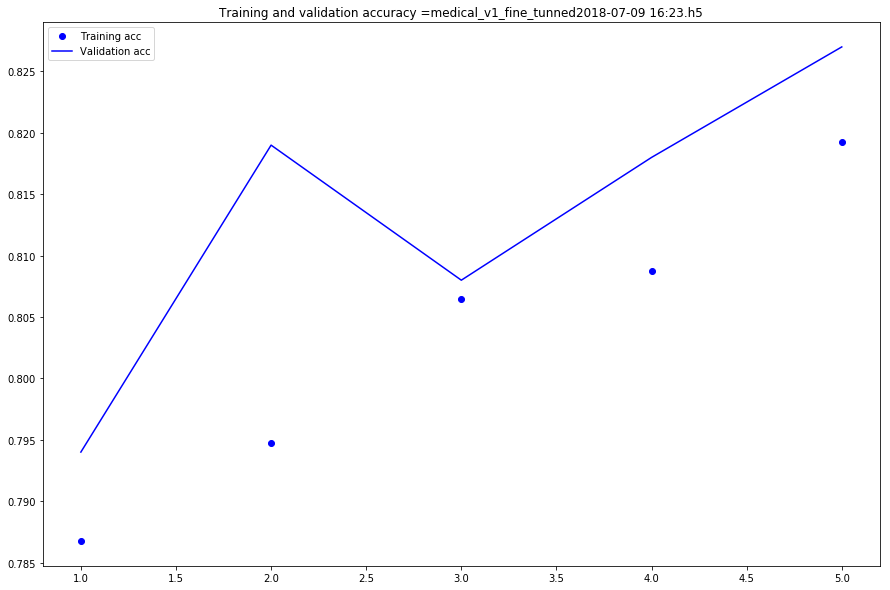

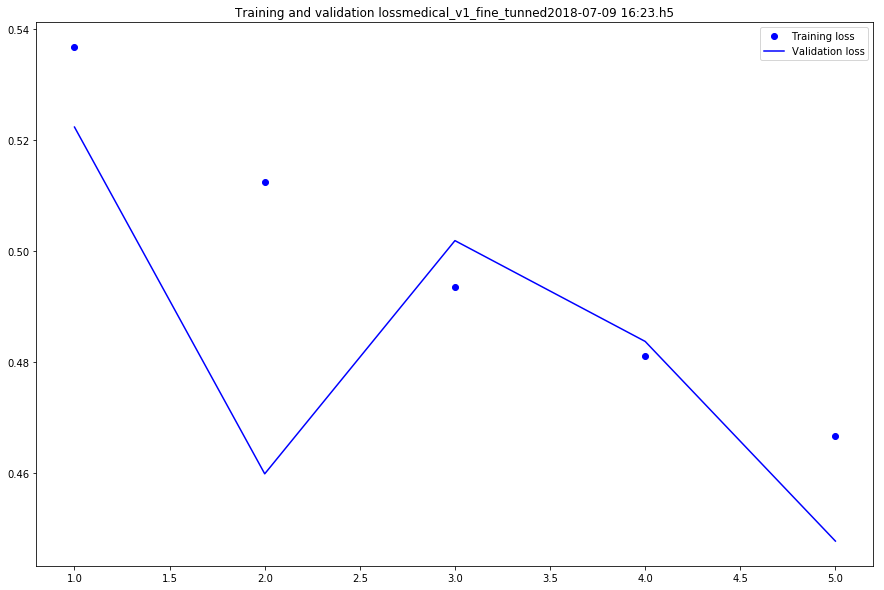

In [60]:
plt.figure()

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
title_string = 'Training and validation accuracy =' + model_name_string
plt.title(title_string)
plt.legend()

# To save plots - added by me
plot_name = title_string + '.tiff'
plot_fname = os.path.join(plot_dir, plot_name)
plt.savefig(plot_fname)
##############################

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
title_string = 'Training and validation loss' + model_name_string
plt.title(title_string)
plt.legend()

# To save plots - added by me
plot_name = title_string + '.tiff'
plot_fname = os.path.join(plot_dir, plot_name)
plt.savefig(plot_fname)

In [67]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

In [68]:
model.load_weights('my_models/medical_v1_fine_tunned2018-07-09 16:23.h5')

In [69]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=training_steps_per_epoch,
    epochs=no_of_epochs,
    validation_data=validation_generator,
    validation_steps=validation_steps)

Epoch 1/5
80/80 [==============================] - 88s 1s/step - loss: 0.4580 - acc: 0.8177 - val_loss: 0.4248 - val_acc: 0.8370
Epoch 2/5
80/80 [==============================] - 79s 987ms/step - loss: 0.4294 - acc: 0.8282 - val_loss: 0.4464 - val_acc: 0.8240
Epoch 3/5
80/80 [==============================] - 79s 983ms/step - loss: 0.4199 - acc: 0.8322 - val_loss: 0.4334 - val_acc: 0.8330
Epoch 4/5
80/80 [==============================] - 79s 982ms/step - loss: 0.4089 - acc: 0.8392 - val_loss: 0.4519 - val_acc: 0.8230
Epoch 5/5
80/80 [==============================] - 79s 989ms/step - loss: 0.3952 - acc: 0.8440 - val_loss: 0.4805 - val_acc: 0.8160


In [70]:
model_name_string = 'medical_v1_fine_tunned' + datetime.datetime.now().strftime("%Y-%m-%d %H:%M") + '.h5'
model_fname = os.path.join(model_dir, model_name_string)
model.save(model_fname)
print('Fined tunened Model saved')

Fined tunened Model saved


In [71]:
model_fname

'my_models/medical_v1_fine_tunned2018-07-09 17:03.h5'

In [72]:
history_sting= 'history_of_v6_medical_fine_tunned' + datetime.datetime.now().strftime("%Y-%m-%d %H:%M")
history_fname = os.path.join(history_dir, history_sting)
f = open(history_fname, "wb+")
pickle.dump(history.history, f)
f.close()
print('History of the model saved')

History of the model saved


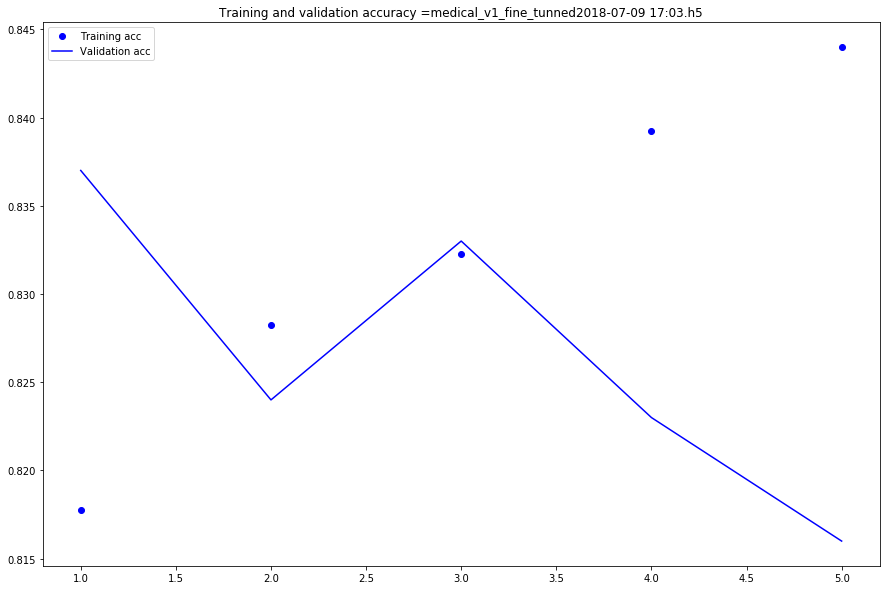

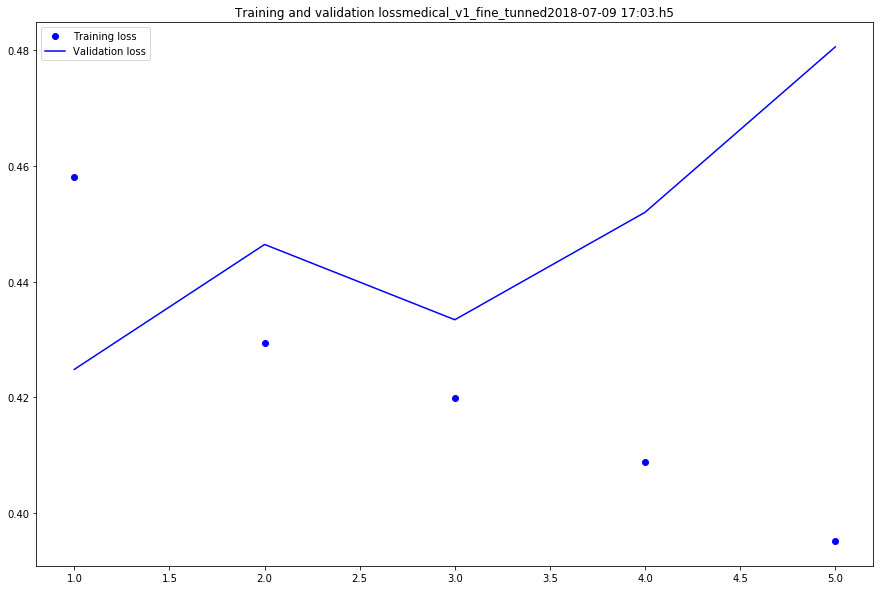

In [73]:
plt.figure()

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
title_string = 'Training and validation accuracy =' + model_name_string
plt.title(title_string)
plt.legend()

# To save plots - added by me
plot_name = title_string + '.tiff'
plot_fname = os.path.join(plot_dir, plot_name)
plt.savefig(plot_fname)
##############################

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
title_string = 'Training and validation loss' + model_name_string
plt.title(title_string)
plt.legend()

# To save plots - added by me
plot_name = title_string + '.tiff'
plot_fname = os.path.join(plot_dir, plot_name)
plt.savefig(plot_fname)

In [18]:
model = models.load_model('my_models/medical_v1_fine_tunned2018-07-09 17:03.h5')

In [21]:
test_loss, test_acc = model.evaluate_generator(test_generator, test_steps)

In [22]:
print('Test acc = ', test_acc)

Test acc =  0.8264999926090241


In [23]:
print('Test loss =', test_loss)

Test loss = 0.4746455933898687
